Epoch 1/50


/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7735/7735 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 0.0120 - mae: 0.0536 - val_loss: 0.0026 - val_mae: 0.0396
Epoch 2/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - loss: 5.5942e-04 - mae: 0.0182 - val_loss: 0.0079 - val_mae: 0.0760
Epoch 3/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 3.1611e-04 - mae: 0.0133 - val_loss: 0.0100 - val_mae: 0.0809
Epoch 4/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - loss: 2.6101e-04 - mae: 0.0120 - val_loss: 0.0079 - val_mae: 0.0711
Epoch 5/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 64s 8ms/step - loss: 2.2062e-04 - mae: 0.0109 - val_loss: 0.0072 - val_mae: 0.0675
Epoch 6/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - loss: 1.9269e-04 - mae: 0.0103 - val_loss: 0.0056 - val_mae: 0.0578
Epoch 7/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - loss: 1.7783e-04 - mae: 0.0097 - val_loss: 0.0068 - val_mae: 0.0642
Epoch 8/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 67s 9ms/step - loss: 1.6303e-04 - mae: 0.0093 - val_loss: 0.0056 - val_mae: 0.0557
Epoch 9/50
7735

7735/7735 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Train Features Shape: (247496, 1)
Test Features Shape: (61875, 1)
MAE: 0.008779279437592491
RMSE: 0.026481132159782074
R² Score: 0.9772845246272335


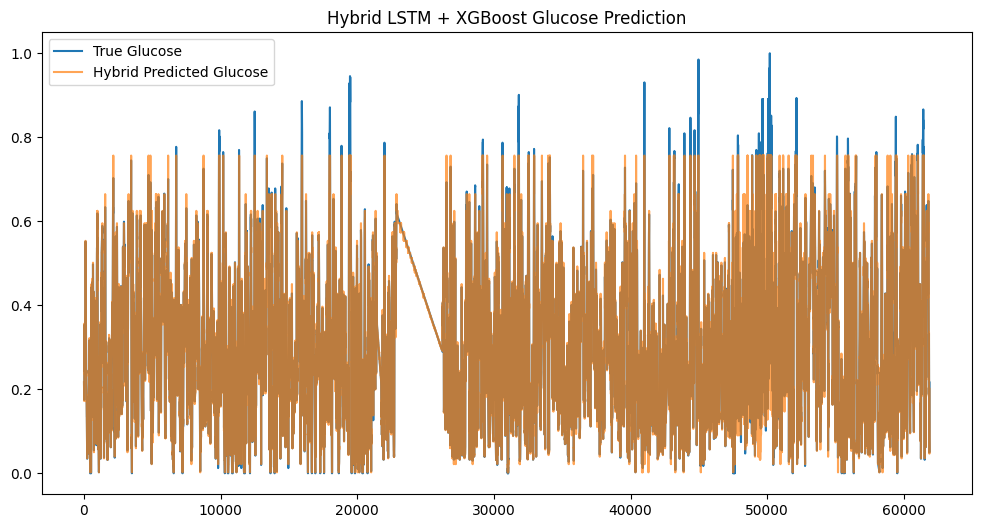

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# 3. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 4. Prepare Sequences for LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Ensure the shapes of y_train and y_test are correct
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 6. Define LSTM Model for Feature Extraction

feature_extractor = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  
])

feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train LSTM model for feature extraction

feature_extractor.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=32,
    verbose=1
)

# Save the LSTM model for feature extraction
feature_extractor.save('lstm_feature_extractor.h5')

# Extract features from LSTM
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# Verify the feature shapes
print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)

# 7. Train XGBoost Model

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(train_features, y_train)

# Save the XGBoost model
xgb_model.save_model('xgboost_model.json')

# 8. Evaluate Hybrid Model
y_pred = xgb_model.predict(test_features)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# 9. Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Glucose')
plt.plot(y_pred, label='Hybrid Predicted Glucose', alpha=0.7)
plt.legend()
plt.title('Hybrid LSTM + XGBoost Glucose Prediction')
plt.show()

# Save predictions
hybrid_predictions = pd.DataFrame({'True Glucose': y_test, 'Hybrid Predicted Glucose': y_pred})
hybrid_predictions.to_csv('hybrid_glucose_predictions.csv', index=False)


In [ ]:
import xgboost as xgb

# Load the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('/path/to/xgboost_model.json')  # Provide the correct path to the saved model

# Now you can generate predictions
full_data_predictions = xgb_model.predict(test_features)
full_predictions_df = pd.DataFrame({'True Glucose': y_test, 'Predicted Glucose': full_data_predictions})

# If you want to aggregate predictions by day or month
full_predictions_df['Date'] = data['time'].iloc[-len(y_test):].dt.date
full_predictions_df = full_predictions_df.groupby('Date').agg({'True Glucose': 'mean', 'Predicted Glucose': 'mean'})

# Plot the yearly predictions
plt.figure(figsize=(12, 6))
plt.plot(full_predictions_df.index, full_predictions_df['True Glucose'], label='True Glucose')
plt.plot(full_predictions_df.index, full_predictions_df['Predicted Glucose'], label='Predicted Glucose', alpha=0.7)
plt.legend()
plt.title('Glucose Prediction for a Year (Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Glucose Level')
plt.xticks(rotation=45)
plt.show()


NameError: name 'xgb_model' is not defined